In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_classif, RFE, chi2, SequentialFeatureSelector
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from lazypredict.Supervised import LazyClassifier
from IPython.display import display

pd.options.display.float_format = '{:,.4f}'.format

In [2]:
# Data Loader loads data from UCI-ML Repo
def load_datasets():
    # Classification Datasets
    c_cancer = pd.read_csv("./Classification.CancerMB.csv").iloc[:, :32]
    c_mice_expression = pd.read_csv("./Classification.Mice.Expression.csv")#.iloc[:, :25]
    c_adult_income = pd.read_csv("./Classification.Adult.Income.csv")
    # Regression Datasets
    r_life_expectancy = pd.read_csv("./Regression.Life.Expectancy.csv")
    
    return c_cancer, c_mice_expression, c_adult_income, r_life_expectancy

In [3]:
# This function performs a missing value analysis on each column of the dataset, helps you decide on what to do in cleaning process
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64' and df[column].dtype != 'int64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())

        
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

In [4]:
# This function drops any null columns and missing values
# This is where you decide whether to remove NULL rows (which will reduce the size of Dataset) or remove NULL columns entirely. You can also choose a combination of both.
def clean_data(df, drop_columns, missing_value = False):
    # Remove unnecessary columns
    df.drop(drop_columns, axis=1, inplace=True)
    # Drop rows with any missing values
    if missing_value == False:
        df.dropna(inplace=True)
    else:
        df.fillna(missing_value, inplace=True)
    return df

In [5]:
# Transforms categorical and numberical data into numerical data
def transform_data(df):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    print("Categorical columns:", df.select_dtypes(include=['object']).columns)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Standardize numerical features
    scaler = StandardScaler()
    print("Numerical columns:", df.select_dtypes(include=['float64', 'int64']).columns)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

In [6]:
def LR(df, target_name, folds):
    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    # Apply MinMax scaling to ensure non-negative values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize the classifiers
    lr_classifier = LogisticRegression()
    rf_classifier = RandomForestClassifier()

    # Initialize k-fold cross-validation where folds > 0
    for k in folds:
        if k > 0:
            k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

            # Apply chi-squared filter
            X_chi2 = SelectKBest(score_func=chi2, k=10).fit_transform(X_scaled, y)
            lr_chi2_scores = cross_val_score(lr_classifier, X_chi2, y, cv=k_fold, scoring='accuracy')
            rf_chi2_scores = cross_val_score(rf_classifier, X_chi2, y, cv=k_fold, scoring='accuracy')
            lr_chi2_mean_accuracy = lr_chi2_scores.mean()
            rf_chi2_mean_accuracy = rf_chi2_scores.mean()

            # Apply forward selection wrapper
            lr_forward_selector = SequentialFeatureSelector(lr_classifier, n_features_to_select=10, direction='forward')
            X_forward = lr_forward_selector.fit_transform(X_scaled, y)
            lr_forward_scores = cross_val_score(lr_classifier, X_forward, y, cv=k_fold, scoring='accuracy')
            rf_forward_scores = cross_val_score(rf_classifier, X_forward, y, cv=k_fold, scoring='accuracy')
            lr_forward_mean_accuracy = lr_forward_scores.mean()
            rf_forward_mean_accuracy = rf_forward_scores.mean()

            # Apply backward selection wrapper
            lr_backward_selector = SequentialFeatureSelector(lr_classifier, n_features_to_select=10, direction='backward')
            X_backward = lr_backward_selector.fit_transform(X_scaled, y)
            lr_backward_scores = cross_val_score(lr_classifier, X_backward, y, cv=k_fold, scoring='accuracy')
            rf_backward_scores = cross_val_score(rf_classifier, X_backward, y, cv=k_fold, scoring='accuracy')
            lr_backward_mean_accuracy = lr_backward_scores.mean()
            rf_backward_mean_accuracy = rf_backward_scores.mean()

            # Apply PCA
            pca = PCA(n_components=10)
            X_pca = pca.fit_transform(X_scaled)
            lr_pca_scores = cross_val_score(lr_classifier, X_pca, y, cv=k_fold, scoring='accuracy')
            rf_pca_scores = cross_val_score(rf_classifier, X_pca, y, cv=k_fold, scoring='accuracy')
            lr_pca_mean_accuracy = lr_pca_scores.mean()
            rf_pca_mean_accuracy = rf_pca_scores.mean()

            results.append({
                'k': k,
                'LR with Chi2 Accuracy': lr_chi2_mean_accuracy,
                'RF with Chi2 Accuracy': rf_chi2_mean_accuracy,
                'LR with Forward Selection Accuracy': lr_forward_mean_accuracy,
                'RF with Forward Selection Accuracy': rf_forward_mean_accuracy,
                'LR with Backward Selection Accuracy': lr_backward_mean_accuracy,
                'RF with Backward Selection Accuracy': rf_backward_mean_accuracy,
                'LR with PCA Accuracy': lr_pca_mean_accuracy,
                'RF with PCA Accuracy': rf_pca_mean_accuracy
            })

        else:
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

            # Train and evaluate Logistic Regression and Random Forest models
            lr_classifier.fit(X_train, y_train)
            lr_pred = lr_classifier.predict(X_test)
            lr_accuracy = accuracy_score(y_test, lr_pred)

            rf_classifier.fit(X_train, y_train)
            rf_pred = rf_classifier.predict(X_test)
            rf_accuracy = accuracy_score(y_test, rf_pred)

            results.append({
                'k': k,
                'LR Accuracy': lr_accuracy,
                'RF Accuracy': rf_accuracy
            })

    df_results = pd.DataFrame(results)
    return df_results

In [7]:
def plot_Heatmap(df):
    # Assuming df is your DataFrame containing the data
    correlation_matrix = df.corr()

    # Plotting the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

In [8]:
# Loading all Datasets into the required variables
c_cancer, c_mice_expression, c_adult_income, r_life_expectancy = load_datasets()

In [9]:
# Load data
c_cancer = pd.read_csv("./Classification.CancerMB.csv").iloc[:, :32]

# Check data types of each column
data_types = c_cancer.dtypes

# Print data types
print(data_types)

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

Column Name: id
Column DataType: float64
Column has null: False


Column Name: diagnosis
Column DataType: int32
Column unique values: [1 0]
Column has null: False


Column Name: radius_mean
Column DataType: float64
Column has null: False


Column Name: texture_mean
Column DataType: float64
Column has null: False


Column Name: perimeter_mean
Column DataType: float64
Column has null: False


Column Name: area_mean
Column DataType: float64
Column has null: False


Column Name: smoothness_mean
Column DataType: float64
Column has null: False


Column Name: compactness_mean
Column DataType: float64
Column has null: False


Column Name: concavity_mean
Column DataType: float64
Column has null: False


Column Name: concave points_mean
Column DataType: float64
Column has null: False


Column Name: symmetry_mean
Column DataType: float64
Column has null: False


Column Name: fractal_dimension_mean
Column DataType: float64
Column has null: False


Column Name: radius_se
Column DataType: float64
Co

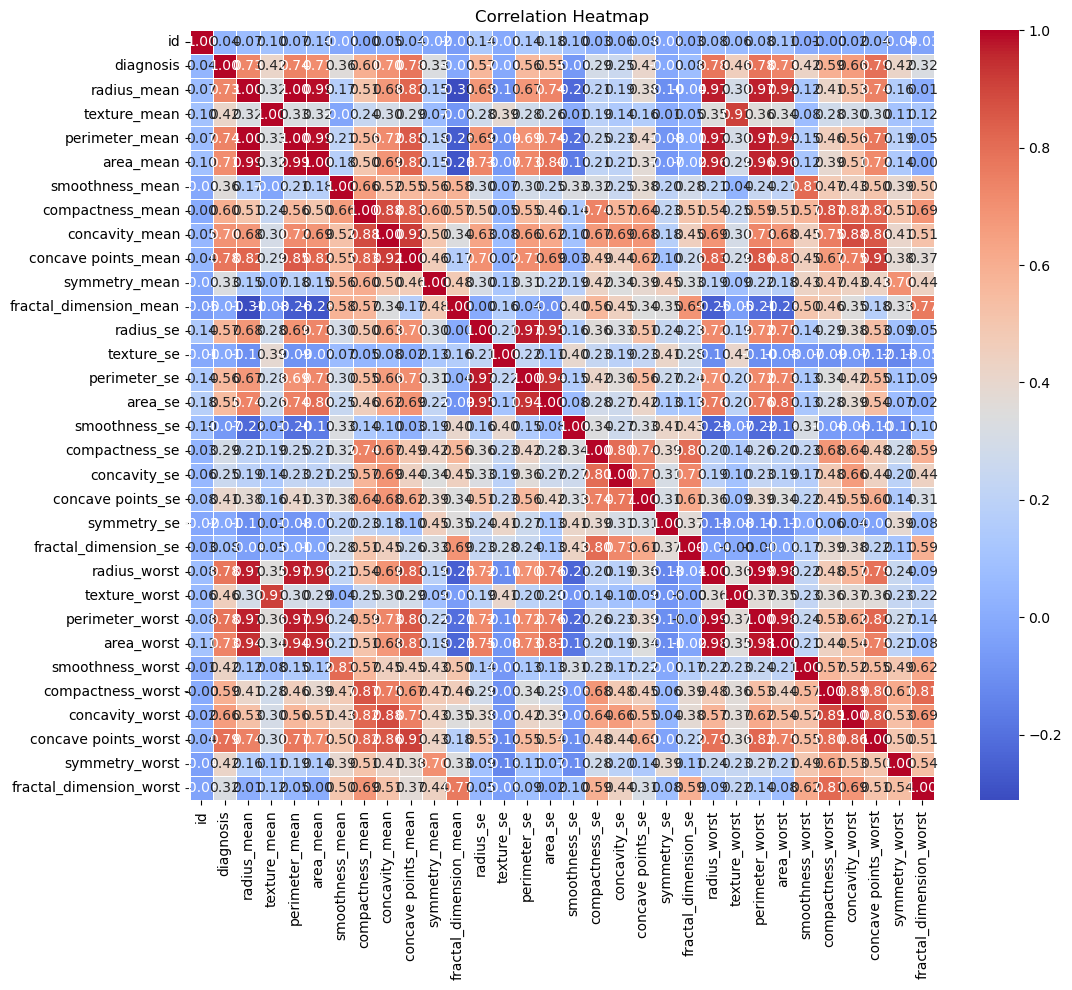

,k,LR Accuracy,RF Accuracy,LR with Chi2 Accuracy,RF with Chi2 Accuracy,LR with Forward Selection Accuracy,RF with Forward Selection Accuracy,LR with Backward Selection Accuracy,RF with Backward Selection Accuracy,LR with PCA Accuracy,RF with PCA Accuracy
0,0,0.9825,0.9561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,NaN,NaN,0.9350,0.9456,0.9684,0.9596,0.9666,0.9578,0.9666,0.9596
2,10,NaN,NaN,0.9386,0.9438,0.9684,0.9579,0.9667,0.9561,0.9649,0.9561
3,20,NaN,NaN,0.9385,0.9474,0.9720,0.9632,0.9702,0.9651,0.9701,0.9507
4,50,NaN,NaN,0.9385,0.9492,0.9721,0.9705,0.9703,0.9635,0.9702,0.9612
5,100,NaN,NaN,0.9390,0.9493,0.9727,0.9673,0.9710,0.9690,0.9723,0.9633


In [12]:
c_cancer
# Checking for Null Values
null_check(c_cancer)
# No Null Values present hence Encoding Categorical Data to Numerical
c_cancer = transform_data(c_cancer)
# Plotting the heatmap
plot_Heatmap(c_cancer)
# The target column in 'diagnosis' hence applying Logistic Regression with and without CV.
c_cancer_results = LR(c_cancer, 'diagnosis', [0, 5, 10, 20, 50, 100])
display(c_cancer_results)

Column Name: MouseID
Column DataType: int32
Column unique values: [ 45  52  53  54  55  56  57  58  59  46  47  48  49  50  51 282 289 290
 291 292 293 294 295 296 283 284 285 286 287 288 357 364 365 366 367 368
 369 370 371 358 359 360 361 362 363  15  22  23  24  25  26  27  28  29
  16  17  18  19  20  21  30  37  38  39  40  41  42  43  44  31  32  33
  34  35  36 297 304 305 306 307 308 309 310 311 298 299 300 301 302 303
 447 454 455 456 457 458 459 460 461 448 449 450 451 452 453 162 169 170
 171 172 173 174 175 176 163 164 165 166 167 168 177 184 185 186 187 188
 189 190 191 178 179 180 181 182 183 267 274 275 276 277 278 279 280 281
 268 269 270 271 272 273 477 484 485 486 487 488 489 490 491 478 479 480
 481 482 483 522 529 530 531 532 533 534 535 536 523 524 525 526 527 528
  75  82  83  84  85  86  87  88  89  76  77  78  79  80  81  90  97  98
  99 100 101 102 103 104  91  92  93  94  95  96 207 214 215 216 217 218
 219 220 221 208 209 210 211 212 213 222 229 230 231 232 2

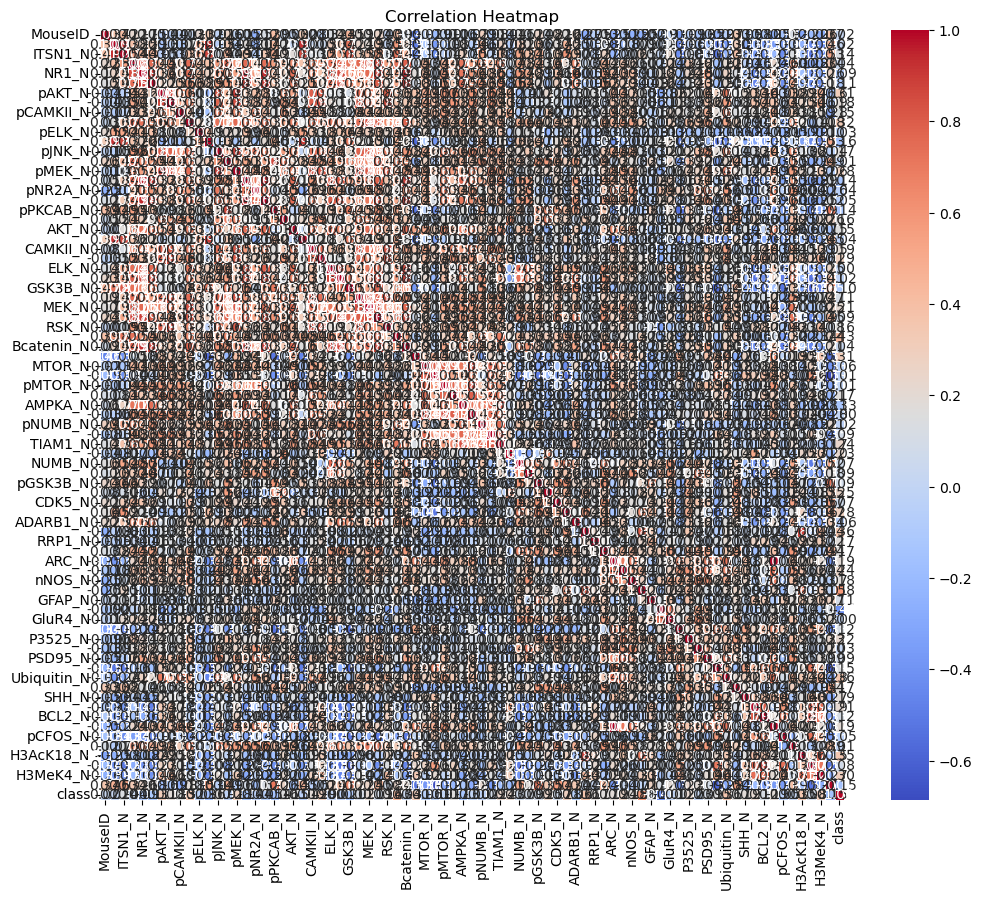

In [ ]:
c_mice_expression
# Checking for Null Values
null_check(c_mice_expression)
# Null Values present hence Removing the data
clean_data(c_mice_expression,[])
# No Null Values present hence Encoding Categorical Data to Numerical
c_mice_expression = transform_data(c_mice_expression)
# Plotting the heatmap
plot_Heatmap(c_mice_expression)
# The target column in 'diagnosis' hence applying Logistic Regression with and without CV.
c_mice_expression_results = LR(c_mice_expression, 'class', [0, 5, 10, 20, 50, 75])
display(c_mice_expression_results)

Column Name: age
Column DataType: int64
Column has null: False


Column Name: workclass
Column DataType: object
Column unique values: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' nan
 'Self-emp-inc' 'Without-pay' 'Never-worked']
Column has null: True
Column Null Count: 2799


Column Name: fnlwgt
Column DataType: int64
Column has null: False


Column Name: education
Column DataType: object
Column unique values: ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
Column has null: False


Column Name: education-num
Column DataType: int64
Column has null: False


Column Name: marital-status
Column DataType: object
Column unique values: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
Column has null: False


Column Name: occupation
Column DataType: object
Column unique values: ['Adm-

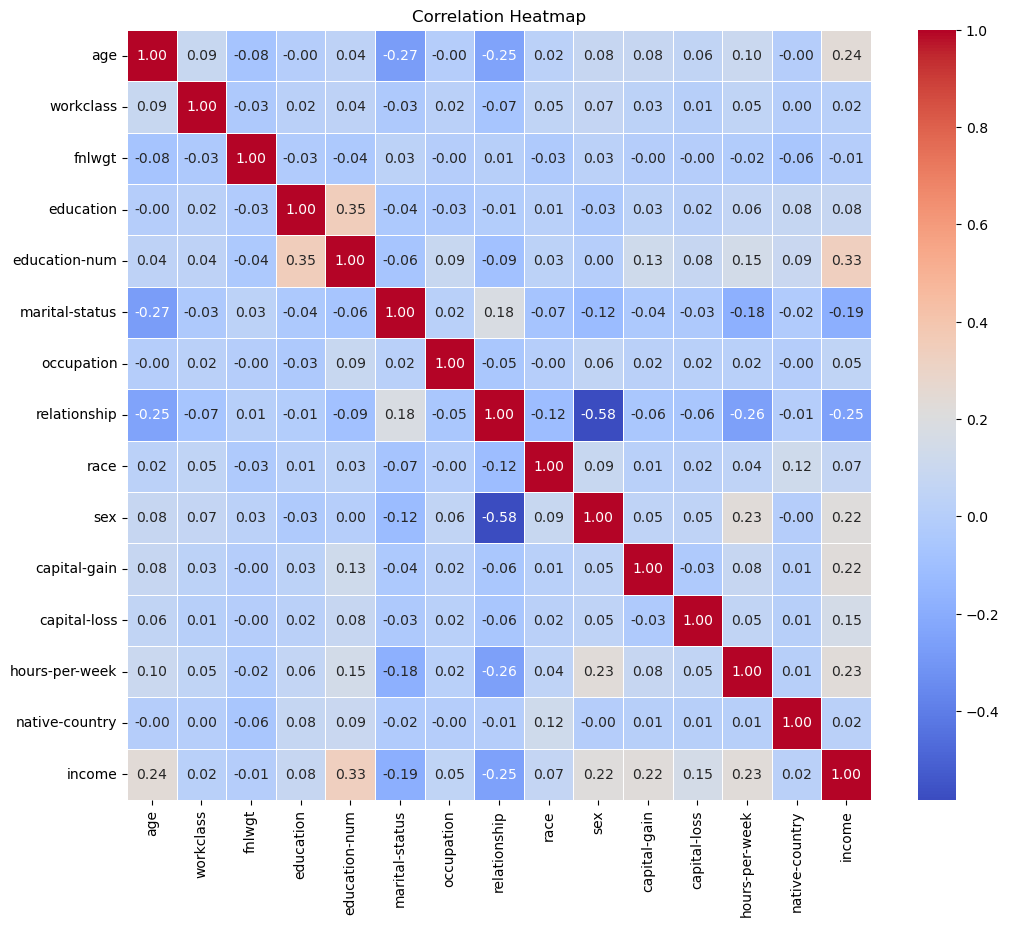

In [ ]:
c_adult_income
# Checking for Null Values
null_check(c_adult_income)
# Null Values present hence Removing the data
clean_data(c_adult_income,[])
# No Null Values present hence Encoding Categorical Data to Numerical
c_adult_income = transform_data(c_adult_income)
# Plotting the heatmap
plot_Heatmap(c_adult_income)
# The target column in 'diagnosis' hence applying Logistic Regression with and without CV.
c_adult_income_results = LR(c_adult_income, 'income', [0, 5, 10, 20, 50, 100])
display(c_adult_income_results)